# Outliers

In this section, we'll be learning about different outlier detection techniques and outlier imputation techniques, by analyzing our simulated customer lifetime value data. In this section, we'll be covering how to: 

**Outlier Detection**
- Box Plots
- Z-Scores
- Isolation Forests
- DBSCAN

**Outlier Treatment**
- Removal
- Winsorize

## Import Libraries

First, we'll need to import the relevant libraries. We'll be using the standard `pandas`, `numpy` libraries for data manipulation. We'll need to use a few functions from `scipy` for our imputation techniques.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

## Load Data

Next, we'll load our customer lifetime value dataset. You'll see in our dataset, we have about 6 columns. The `purchases` column is the column we care about in our customer lifetime value problem. 

In [2]:
df = pd.read_csv(r"C:\Users\RAZER BLADE\OneDrive\Bureau\Python\ML_Process_Course-main\5_data_preprocessing\5_1_missing_values\clv_data.csv")

# Outlier Detection

First, we'll dive into different methods to detect outliers.....

## Box Plot

The first plot we'll use is a boxplot. A boxplot is a method of displaying a distribution of data based off the minimum, maximum lower quartile, upper quartile and the median. An outlier is a datapoint that falls outside the whiskers of the plot. You'll see in this plot, the data point above the whisker would be considered the outlier:

<Axes: ylabel='purchases'>

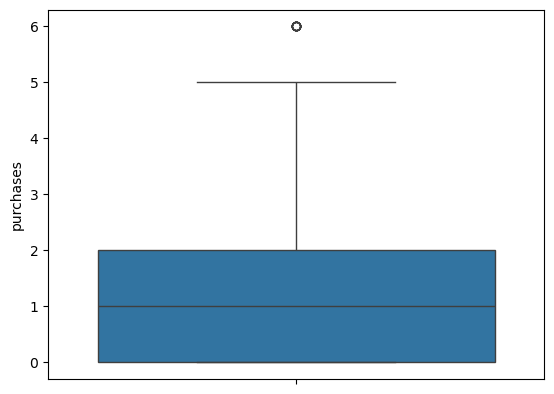

In [3]:
sns.boxplot(df['purchases'])

In [17]:
def extract_outliers_from_boxplot(array):
    ## Get IQR
    q1 = np.quantile(array, 0.25)
    q3 = np.quantile(array, 0.75)
    med = np.median(array)

    # finding the iqr region
    iqr = q3 - q1

    # finding upper and lower whiskers
    upper_bound = q3 + (1.5*iqr)
    lower_bound = q1 - (1.5*iqr)

    outliers = array[(array <= lower_bound) | (array >= upper_bound)]
    outliers = pd.DataFrame(outliers)
    outliers.columns = [array.name + ' outliers']
    print('Number of Outliers within the box plot are :{}'.format(outliers.shape[0]))
    return outliers

extract_outliers_from_boxplot(df['purchases'])

Number of Outliers within the box plot are :59


,purchases outliers
47,5
104,5
142,5
301,5
323,5
485,6
486,5
1026,5
1104,6
1112,5


## Violin Plot

An alternative to a boxplot is a violin plot. A violin plot includes all the data in a boxplot while also adding density forms. This allows you to see how well your points are distributed across the entire dataset: 

{'bodies': [<matplotlib.collections.PolyCollection at 0x1da792c2300>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1da792cca10>,
 'cmins': <matplotlib.collections.LineCollection at 0x1da792ca4e0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1da792cd100>}

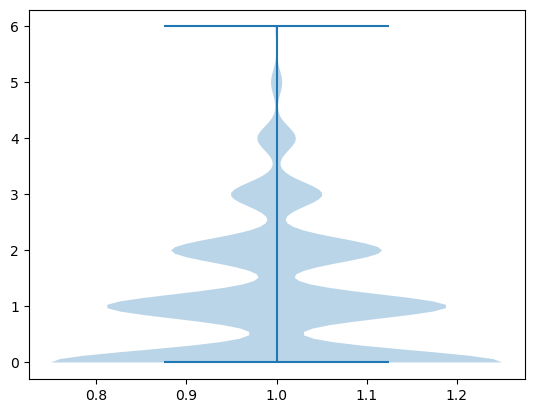

In [9]:
plt.violinplot(df['purchases'])


## Z-Scores

A similar method to boxplots is using z-scores. The core difference, is using z-scores, we can specify the percentile we want to use, to classify a point as an outlier:

In [21]:
purchases = df['purchases']

def percentile_outliers(array,
                        lower_bound_perc,
                        upper_bound_perc):
    
    upper_bound = np.percentile(df['purchases'], upper_bound_perc)
    lower_bound = np.percentile(df['purchases'], lower_bound_perc)
    
    outliers = array[(array <= lower_bound) | (array >= upper_bound)]
    
    return outliers

def z_score_outliers(array,
                     z_score_lower,
                     z_score_upper):

    z_scores = scipy.stats.zscore(array)
    outliers = (z_scores > z_score_upper) | (z_scores < z_score_lower)
    
    return array[outliers]

In [22]:
outliers = percentile_outliers(df['purchases'],
               upper_bound_perc = 99,
               lower_bound_perc = 1)

In [23]:
z_score_outliers(df['purchases'],
                     z_score_lower = -1.96,
                     z_score_upper = 1.96)

28      4
47      5
51      4
67      4
74      4
       ..
4880    4
4895    5
4897    4
4944    4
4958    5
Name: purchases, Length: 227, dtype: int64

## Isolation Forests

The next approach is an algorithm based approach called Isolation Forests. Isolation forest is essentially a decision tree that will randomly select a feature to split on. Outliers would likely get split first by the decision tree, which tells us where the outliers are:  

In [23]:
from sklearn.ensemble import IsolationForest

features = ['age','income','days_on_platform','purchases']

## We'll do a simple drop null for now
df = df.dropna()

## Create a training-test set
X = df[features]
X_train = X[:4000]
X_test = X[1000:]

## Fit Model
clf = IsolationForest(n_estimators=50, max_samples=100)
clf.fit(X_train)

## Get Scores
df['scores'] = clf.decision_function(X_train)
df['anomaly'] = clf.predict(X)

## Get Anomalies
outliers=df.loc[df['anomaly']==-1]

outliers

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
9,9,9,49.0,Female,76842,19.0,Tokyo,2,-0.013258,-1
15,15,15,31.0,Female,226249,20.0,Miami,0,-0.066064,-1
17,17,17,27.0,Female,177582,2.0,London,0,-0.025777,-1
18,18,18,10.0,Female,260,32.0,San Francisco,0,-0.038640,-1
23,23,23,10.0,Female,108804,5.0,Tokyo,2,-0.037620,-1
...,...,...,...,...,...,...,...,...,...,...
4970,4970,4970,34.0,Female,9850,3.0,New York City,3,-0.041662,-1
4979,4979,4979,50.0,Male,90750,71.0,New York City,1,-0.068472,-1
4984,4984,4984,24.0,Female,225155,8.0,San Francisco,2,-0.081438,-1
4990,4990,4990,33.0,Male,3020,89.0,New York City,0,-0.098672,-1


# Outlier Treatment

Now that we have some techniques for detecting outliers, let's look into different ways to treat outliers. 

## Removal

The first method is simply removing our outliers. The typical way to remove outliers is through z-score removal. Specify the z-score or percentile cutoff you want for your outliers, then, remove any point that falls above or below that threshold. We've written out a few functions you can use: 

In [70]:
def z_score_removal(df, column, lower_z_score, upper_z_score):
    
    col_df = df[column]

    z_scores = scipy.stats.zscore(purchases)
    outliers = (z_scores > upper_z_score) | (z_scores < lower_z_score)
    return df[~outliers]

def percentile_removal(df, column, lower_bound_perc, upper_bound_perc):
    
    col_df = df[column]
    
    upper_bound = np.percentile(col_df, upper_bound_perc)
    lower_bound = np.percentile(col_df, lower_bound_perc)

    z_scores = scipy.stats.zscore(purchases)
    outliers = (z_scores > upper_bound) | (z_scores < lower_bound)
    return df[~outliers]

filtered_df = z_score_removal(df, 'purchases', -1.96, 1.96)
percentile_removal(df, 'purchases', lower_bound_perc = 1, upper_bound_perc = 99)

/var/folders/t0/xzfx5w1s3_g0hklj_3fz7dnc0000gn/T/ipykernel_85721/3901871235.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[~outliers]
/var/folders/t0/xzfx5w1s3_g0hklj_3fz7dnc0000gn/T/ipykernel_85721/3901871235.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[~outliers]


,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
3,3,3,29.0,Male,43791,28.0,London,2,0.035400,1
4,4,4,18.0,Female,132181,26.0,London,2,0.012816,1
9,9,9,49.0,Female,76842,19.0,Tokyo,2,-0.013258,-1
23,23,23,10.0,Female,108804,5.0,Tokyo,2,-0.037620,-1
25,25,25,46.0,Female,112992,9.0,London,3,-0.055919,-1
...,...,...,...,...,...,...,...,...,...,...
4953,4953,4953,33.0,Male,90302,21.0,Tokyo,3,-0.005375,-1
4958,4958,4958,47.0,Female,79452,4.0,New York City,5,-0.110638,-1
4970,4970,4970,34.0,Female,9850,3.0,New York City,3,-0.041662,-1
4984,4984,4984,24.0,Female,225155,8.0,San Francisco,2,-0.081438,-1


## Winsorize

Dropping outliers is the crudest approach. If you feel those rows are valuable, we can winsorize, also known as "capping" our outliers. Rather than keep the outlier value, if the value falls above a specific threshold, we can replace the outlier with that threshold value. Here, we've written a function for you: 

In [71]:
def winsorize(df, column, upper, lower):
    col_df = df[column]
    
    perc_upper = np.percentile(df[column],upper)
    perc_lower = np.percentile(df[column],lower)
    
    df[column] = np.where(df[column] >= perc_upper, 
                          perc_upper, 
                          df[column])
    
    df[column] = np.where(df[column] <= perc_lower, 
                          perc_lower, 
                          df[column])
    
    return df

In [72]:
winsorize(df, 'purchases', 97.5, 0.025)

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
2,2,2,24.0,Male,104723,34.0,London,1.0,0.040114,1
3,3,3,29.0,Male,43791,28.0,London,2.0,0.035400,1
4,4,4,18.0,Female,132181,26.0,London,2.0,0.012816,1
5,5,5,23.0,Male,12315,14.0,New York City,0.0,0.030720,1
8,8,8,46.0,Male,129157,23.0,New York City,0.0,0.006113,1
...,...,...,...,...,...,...,...,...,...,...
4986,4986,4986,23.0,Male,75425,6.0,London,1.0,0.056240,1
4989,4989,4989,47.0,Female,84987,30.0,Tokyo,0.0,0.021393,1
4990,4990,4990,33.0,Male,3020,89.0,New York City,0.0,-0.098672,-1
4991,4991,4991,36.0,Female,26173,34.0,Tokyo,0.0,0.044223,1


## Additional Outlier Detection Techniques

On top of these methods, there are many other methods:

- Mahalanobis Distance: This is a distance metric that helps us detect multivariate outliers. 
- Robust Mahalanobis Distance: Adds a layer on the original, by only using data points where the determinant of the covariance matrix is as small as possible. 

There are a number of additional Algorithm-Based techniques:

- DBScan Cluster Outlier Detection
- K-Means Cluster Outlier Detection
- Hierarchical Clustering Detection 

There are also algorithms that are robust to outliers, so you don't need to worry as much if you're using these models:

- Random Forest
- Gradient Boosted Trees

We will add these methods in future iterations of the course. 

## Conclusion

In conclusion, we've gone over both techniques for detecting outliers and treating outliers. To review, we went over the following methods for detecting outliers: 

- Box Plots
- Violin Plots
- Z-score method
- Percentile Method
- Isolation Forests

To treat outliers, we went over: 

- Z-score Removal
- Winsorizing